In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns


from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta


data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')

In [3]:
def crosscorr(series1, series2, lag=0):
    """ Lag-N cross correlation.
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return series2.corr(series1.shift(lag))


def compute_correlation(series2, series1, lags = list(range(10)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(series1.index.values[0], series2.index.values[0])
    if not final_day:
        final_day = min(series1.index.values[-1], series2.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    series1 = series1.loc[start_day:max_date]
    series2 = series2.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[ lag ]['value'] = crosscorr(series1, series2, lag=lag)

    return corr_df

In [4]:
rt_df = pd.read_csv( os.path.join(results_dir, 'bog_rt', 'rt_df_bog_confirmation.csv') )
rt_df = rt_df[rt_df["variable"]=='R']
rt_df['date'] = rt_df['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))


cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])

In [18]:

# graphs attr in ['graph_size', 'number_of_contacts', 'pagerank_gini_index', 'personalized_pagerank_gini_index']

graphs_att_df = pd.read_csv(os.path.join(results_dir, "data", "graph_attributes", "graphs_attributes_08-06-2021.csv"), parse_dates=["date"])
pr_df = graphs_att_df[graphs_att_df.attribute_name.isin(['pagerank_gini_index', 'personalized_pagerank_gini_index'])]


,location_id,date,attribute_name,attribute_value,type
6320,colombia_bogota_localidad_santa_fe,2020-02-09,pagerank_gini_index,0.309961,locality
6321,colombia_bogota_localidad_usme,2020-02-09,pagerank_gini_index,0.467004,locality
6322,colombia_bogota_localidad_los_martires,2020-02-09,pagerank_gini_index,0.536595,locality
6323,colombia_bogota,2020-02-09,pagerank_gini_index,0.489212,city
6324,colombia_bogota_localidad_kennedy,2020-02-09,pagerank_gini_index,0.458050,locality
...,...,...,...,...,...
12475,colombia_bogota_localidad_san_cristobal,2021-05-22,personalized_pagerank_gini_index,0.538739,locality
12476,colombia_bogota_localidad_antonio_narino,2021-05-22,personalized_pagerank_gini_index,0.473863,locality
12477,colombia_bogota_localidad_barrios_unidos,2021-05-22,personalized_pagerank_gini_index,0.424540,locality
12478,colombia_bogota_localidad_ciudad_bolivar,2021-05-22,personalized_pagerank_gini_index,0.585195,locality


In [6]:
ppr_bog_df = pr_df[pr_df["attribute_name"]=="personalized_pagerank_gini_index"]
pr_bog_df  = pr_df[pr_df["attribute_name"]=="pagerank_gini_index"]

ppr_bog_df = ppr_bog_df.set_index('date') #
ppr_bog_df = ppr_bog_df[["attribute_value"]].resample('1D').mean()#.interpolate(method='polynomial', order=2)
ppr_bog_df = ppr_bog_df.interpolate(method='linear', order=2)
ppr_bog_df = ppr_bog_df.reset_index()

pr_bog_df = pr_bog_df.set_index('date') #
pr_bog_df = pr_bog_df[["attribute_value"]].resample('1D').mean()#.interpolate(method='polynomial', order=2)
pr_bog_df = pr_bog_df.interpolate(method='linear', order=2)
pr_bog_df = pr_bog_df.reset_index()

rt_df = pd.read_csv( os.path.join(results_dir, 'bog_rt', 'rt_df_{}_confirmation.csv'.format('bog')))
rt_df = rt_df[rt_df["variable"]=="R"]
rt_df['date'] = rt_df['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))


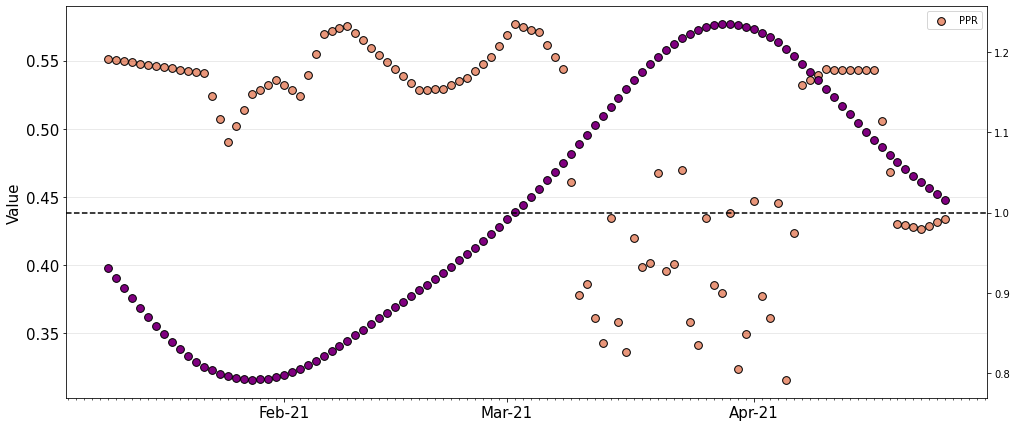

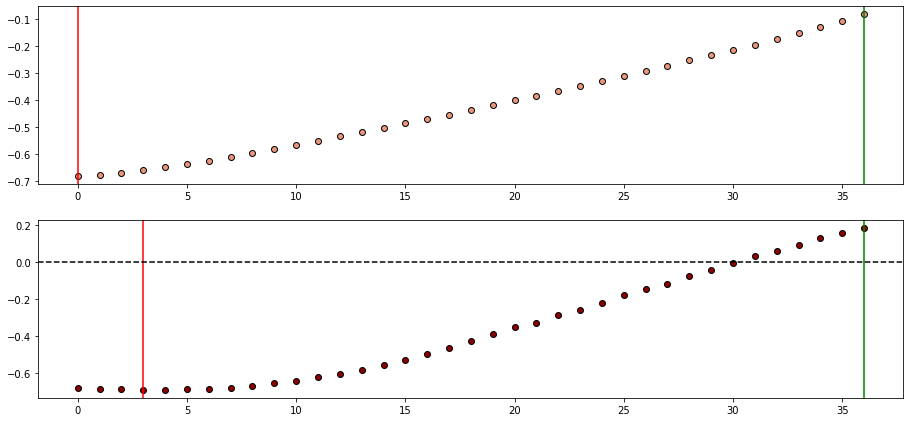

In [8]:
df_all = pd.merge( ppr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)
df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value"], facecolor='darksalmon', edgecolor='k', s=60, label='PPR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


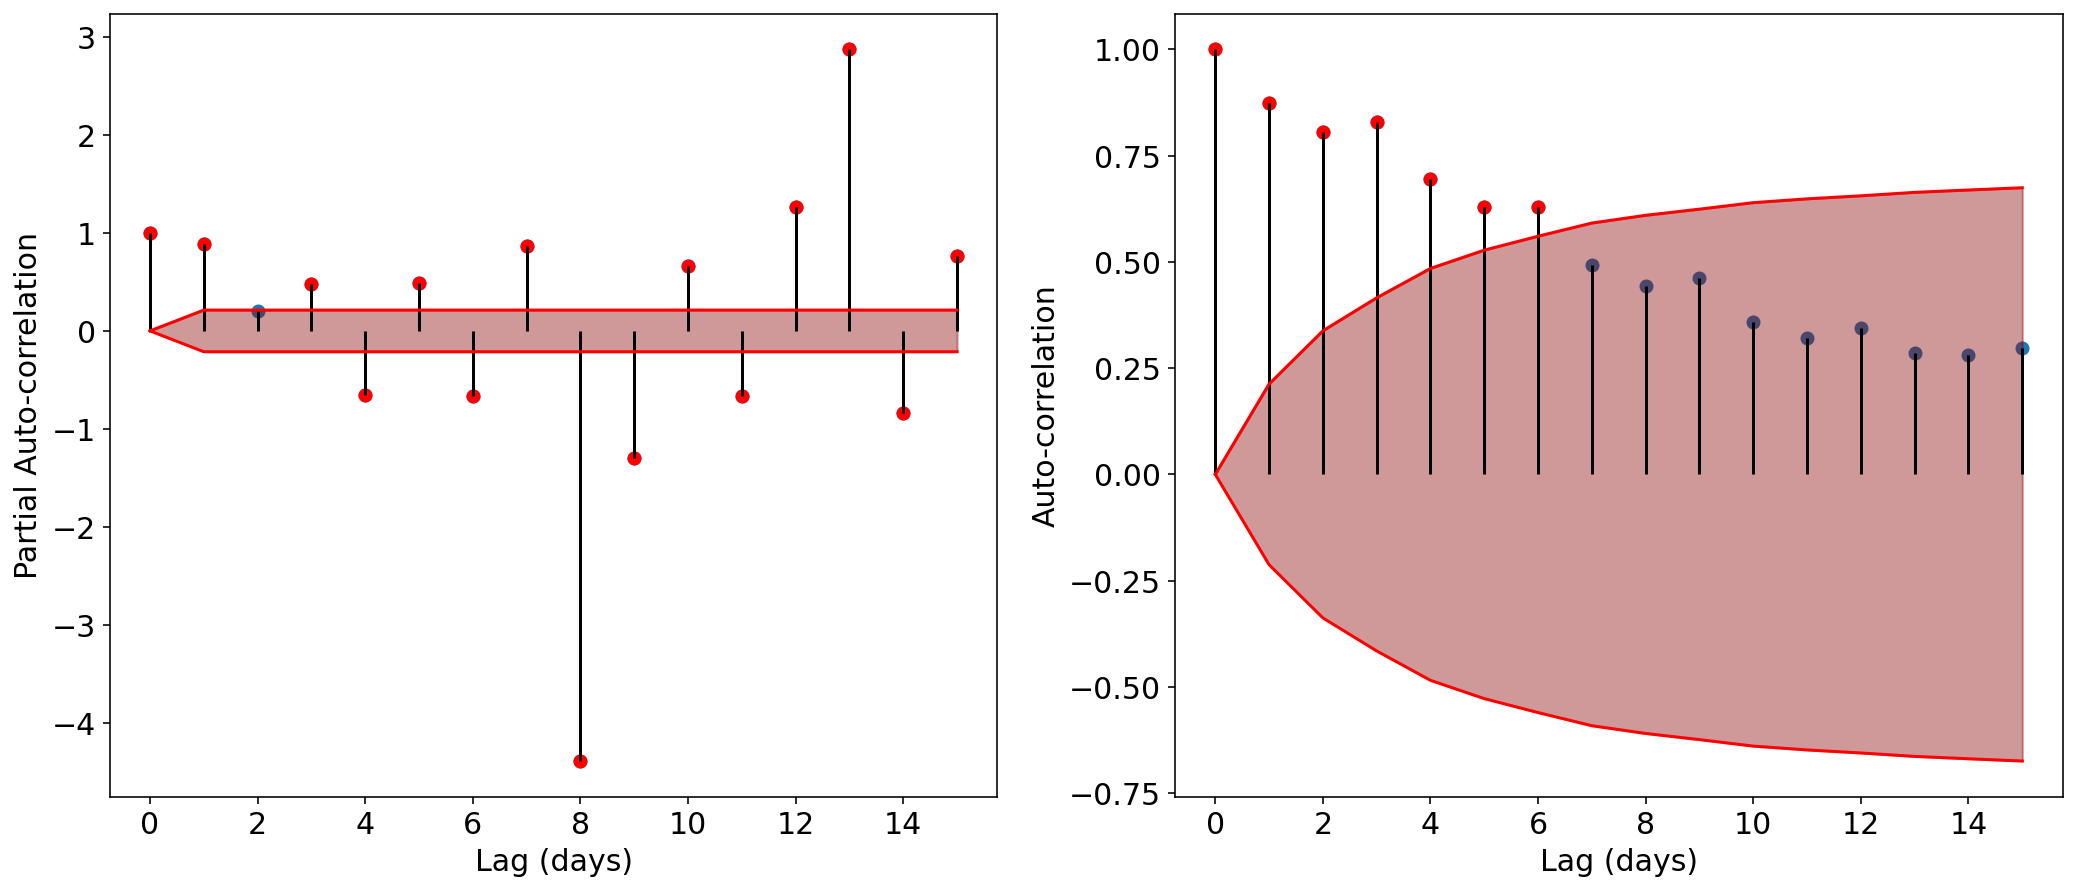

In [131]:
from statsmodels.tsa.stattools import acf, pacf

nlags = 15

a = acf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1, 2, figsize=(17.5, 7.2))

ax[1].scatter(range(nlags+1), a[0],)
ax[1].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[1].vlines(range(nlags+1), [0], a[0], color='k' )
ax[1].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[1].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[1].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Auto-correlation', fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

a = pacf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])
ax[0].scatter(range(nlags+1), a[0],)
ax[0].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[0].vlines(range(nlags+1), [0], a[0], color='k' )
ax[0].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[0].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[0].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[0].set_xlabel('Lag (days)', fontsize=15)
ax[0].set_ylabel('Partial Auto-correlation', fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
plt.show()

# PR

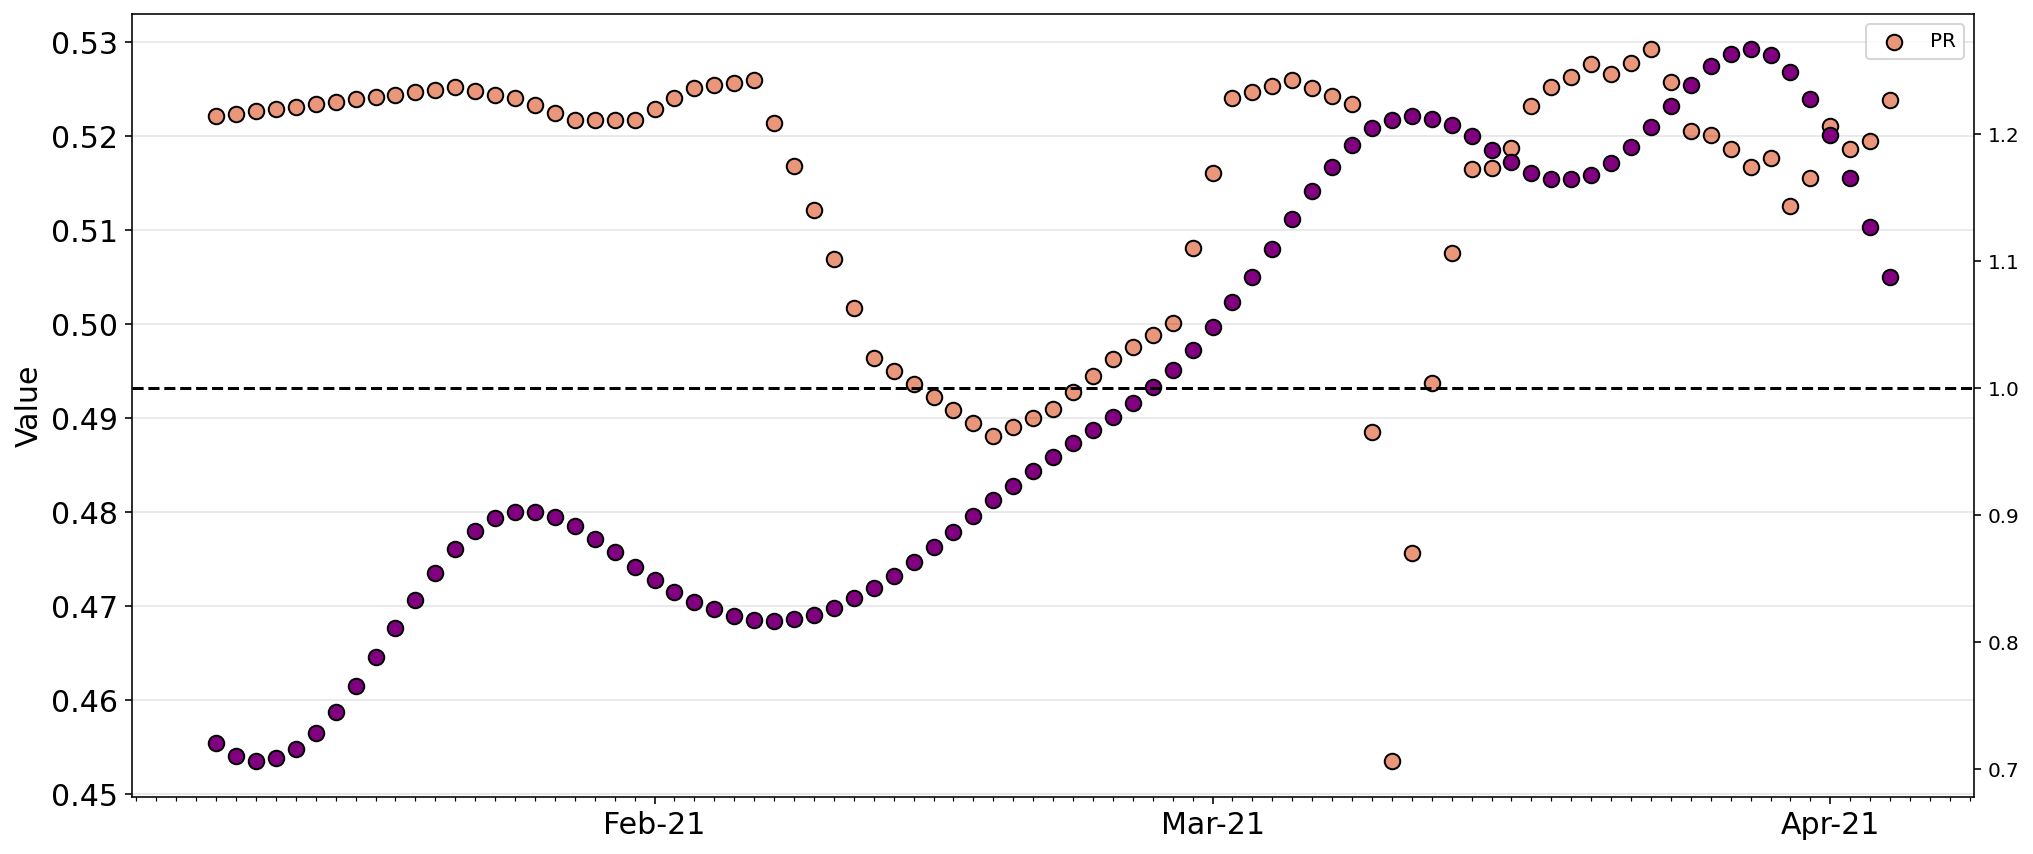

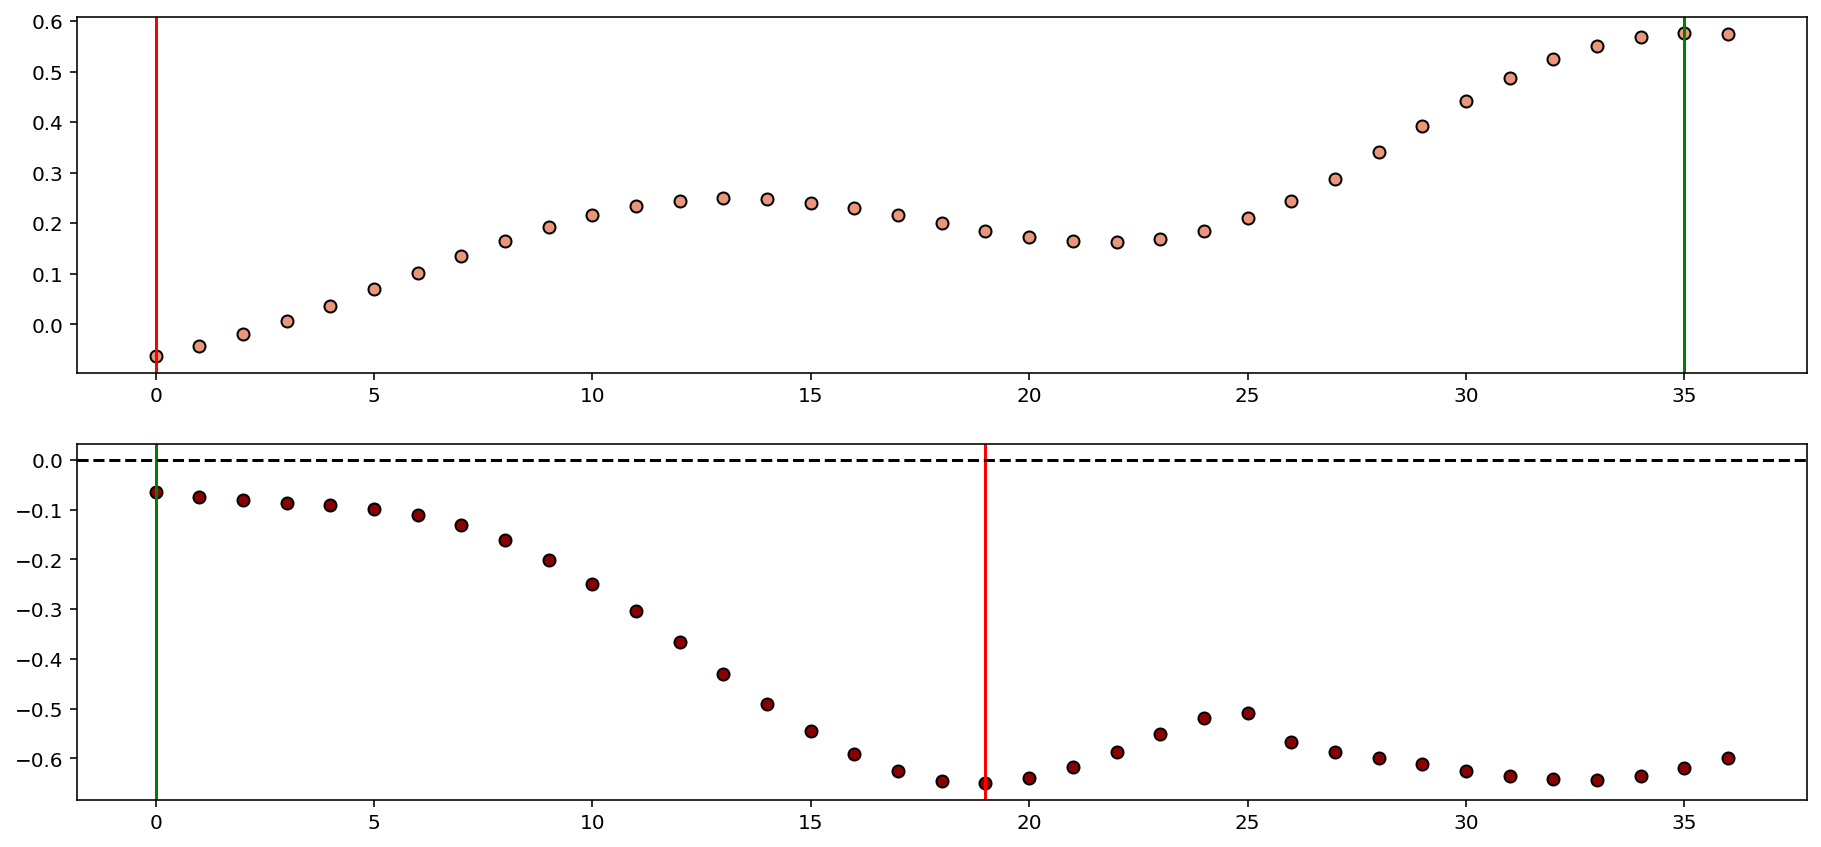

In [132]:
df_all = pd.merge( pr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)

df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()



fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value"], facecolor='darksalmon', edgecolor='k', s=60, label='PR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


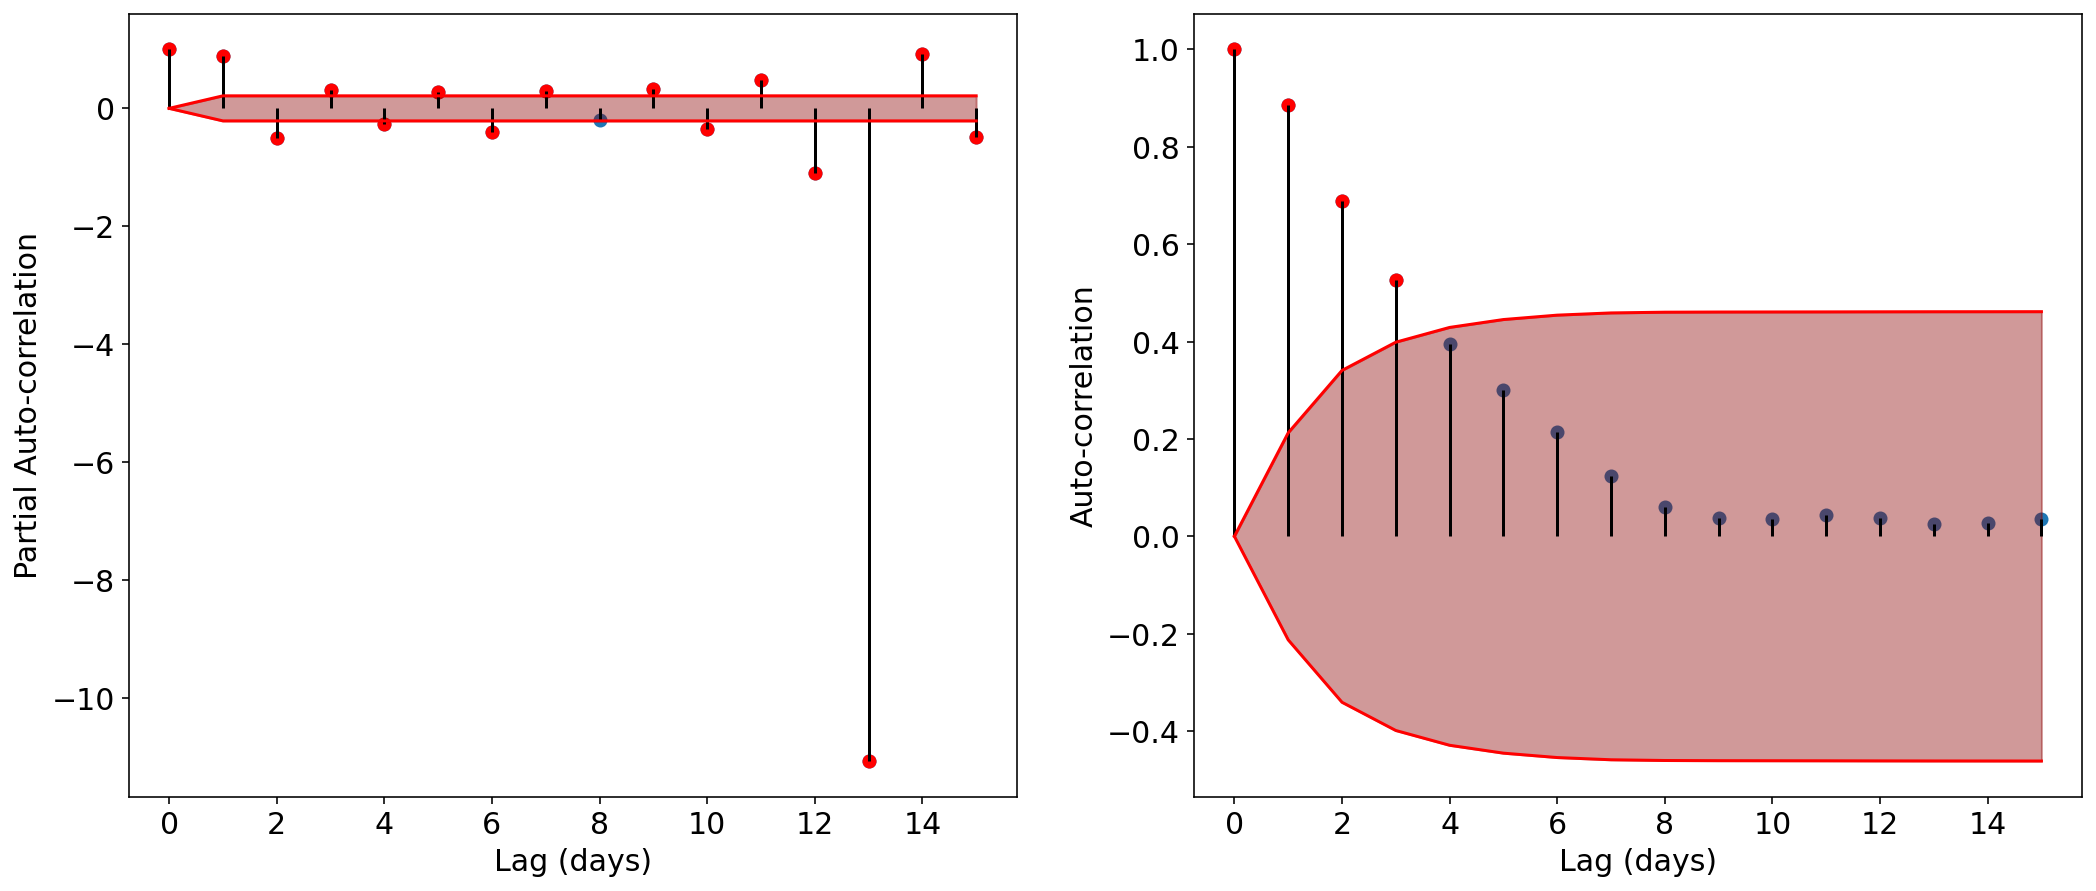

In [133]:
from statsmodels.tsa.stattools import acf, pacf

nlags = 15

a = acf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1, 2, figsize=(17.5, 7.2))

ax[1].scatter(range(nlags+1), a[0],)
ax[1].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[1].vlines(range(nlags+1), [0], a[0], color='k' )
ax[1].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[1].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[1].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Auto-correlation', fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

a = pacf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])
ax[0].scatter(range(nlags+1), a[0],)
ax[0].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[0].vlines(range(nlags+1), [0], a[0], color='k' )
ax[0].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[0].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[0].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[0].set_xlabel('Lag (days)', fontsize=15)
ax[0].set_ylabel('Partial Auto-correlation', fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
plt.show()

In [134]:

ppr_bog_df["attribute_value2"] = 1/ppr_bog_df["attribute_value"]


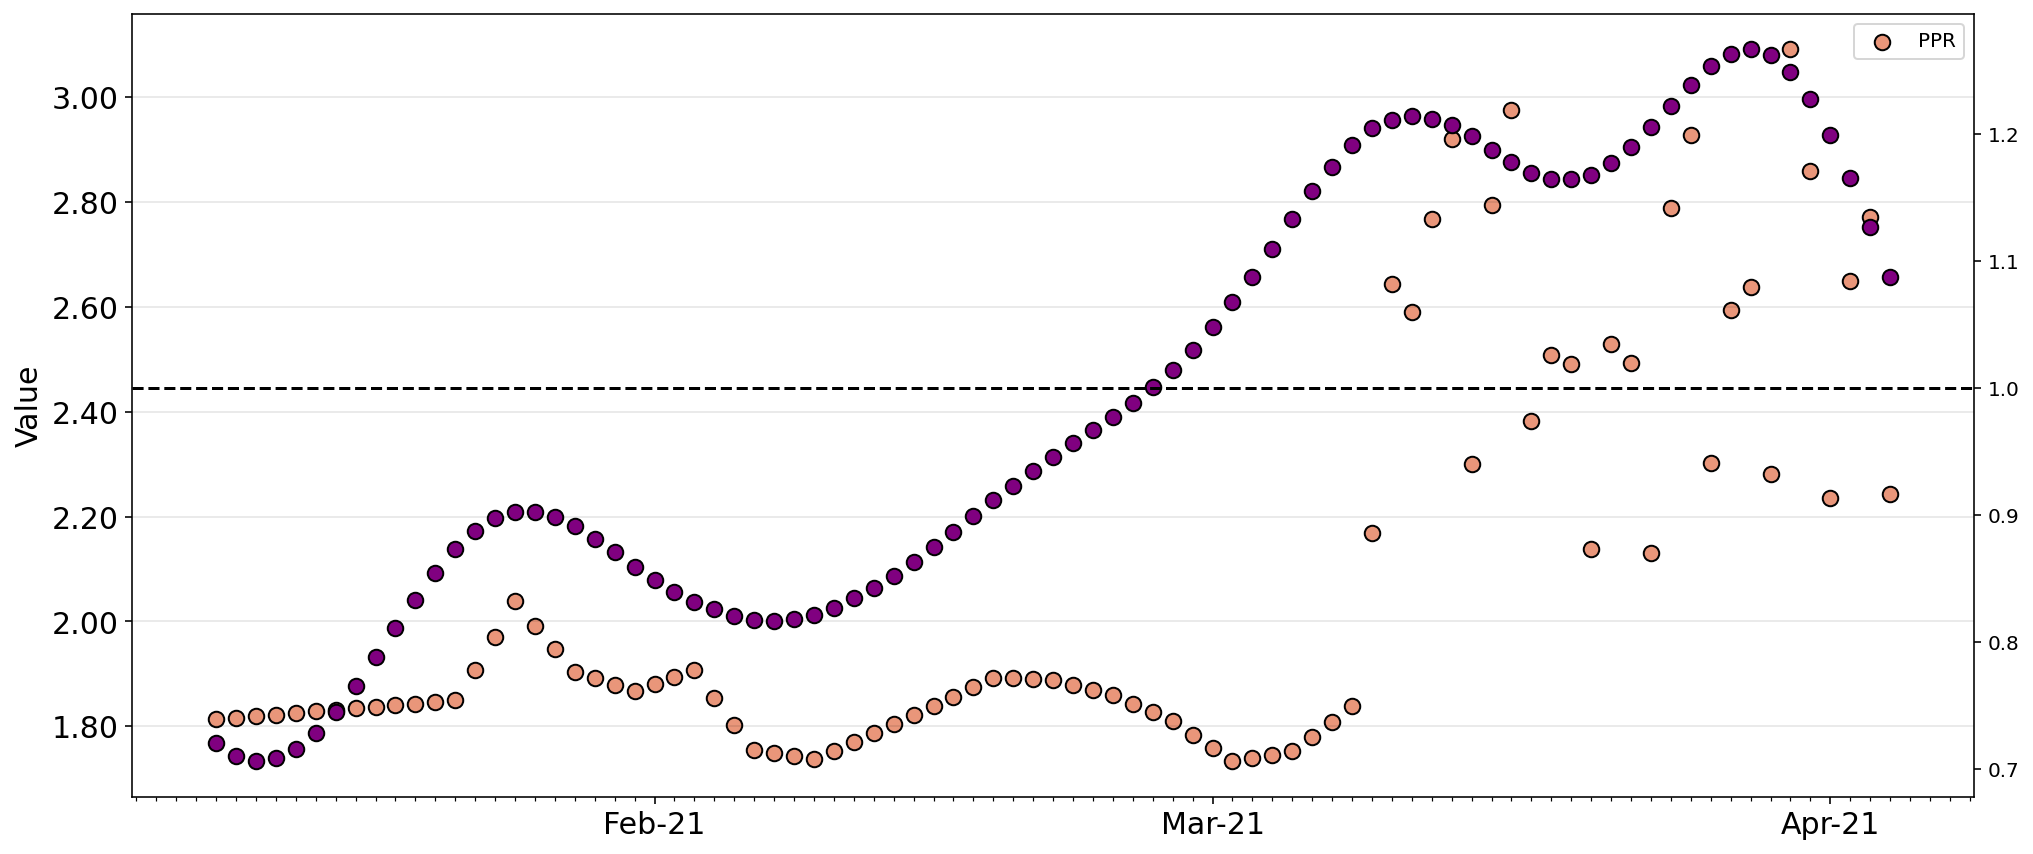

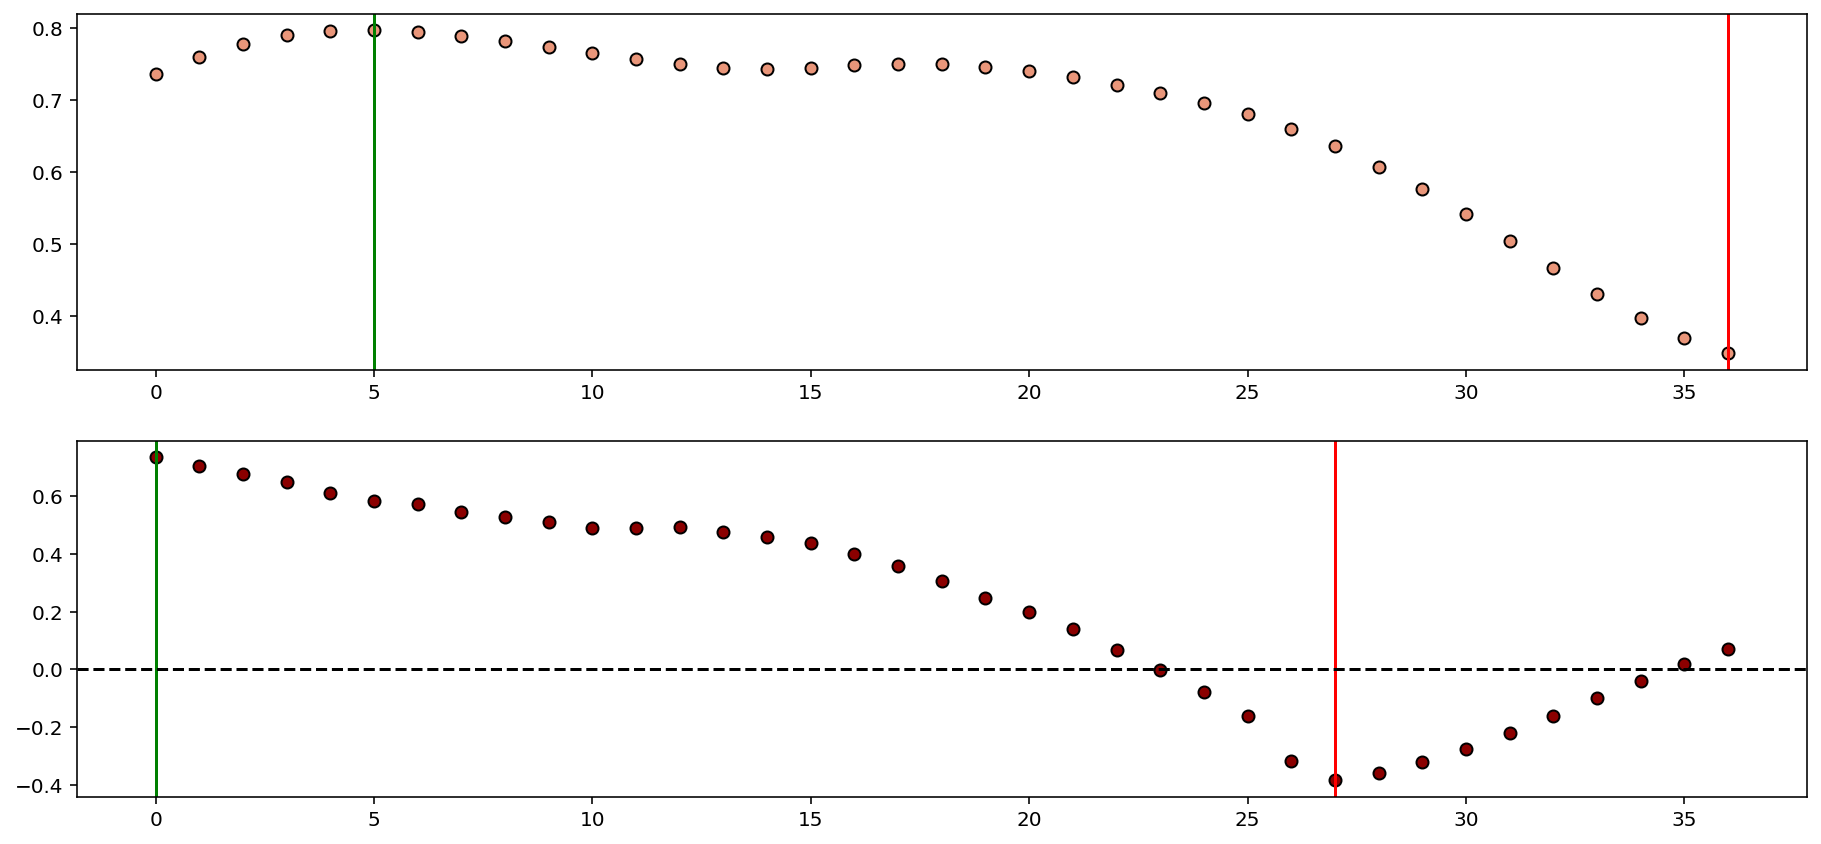

In [136]:
df_all = pd.merge( ppr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)
df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value2", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()



fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value2"], facecolor='darksalmon', edgecolor='k', s=60, label='PPR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value2"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value2"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')


# Locality


In [38]:
rt_df_tomerge, locality_ppr_pr_df

(          date    median     location_id
 0   2020-03-14  1.776741  Antonio Narino
 1   2020-03-15  1.699241  Antonio Narino
 2   2020-03-16  1.616431  Antonio Narino
 3   2020-03-17  1.536636  Antonio Narino
 4   2020-03-18  1.457039  Antonio Narino
 ..         ...       ...             ...
 396 2021-04-14  0.512427            Usme
 397 2021-04-15  0.469276            Usme
 398 2021-04-16  0.431838            Usme
 399 2021-04-17  0.399098            Usme
 400 2021-04-18  0.371212            Usme
 
 [7720 rows x 3 columns],
                  poly_name                    attribute_name  attribute_value
 date                                                                         
 2020-02-09  Antonio Narino               pagerank_gini_index         0.316583
 2020-02-09  Barrios Unidos               pagerank_gini_index         0.309614
 2020-02-09            Bosa               pagerank_gini_index         0.492322
 2020-02-09       Chapinero               pagerank_gini_index         0.4

In [51]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

# graphs attr in ['graph_size', 'number_of_contacts', 'pagerank_gini_index', 'personalized_pagerank_gini_index']
graphs_att_df       = pd.read_csv(os.path.join(results_dir, "data", "graph_attributes", "graphs_attributes_08-06-2021.csv"), parse_dates=["date"])
locality_ppr_pr_df  = graphs_att_df[graphs_att_df.attribute_name.isin(['pagerank_gini_index', 'personalized_pagerank_gini_index'])]
locality_ppr_pr_df["location_id"] = locality_ppr_pr_df["location_id"].apply(lambda x: ' '.join([w.capitalize() for w in x.replace("colombia_bogota_localidad_","" ).split('_')]) )
locality_ppr_pr_df["location_id"]   = locality_ppr_pr_df["location_id"].replace( dict_correct )
locality_ppr_pr_df = locality_ppr_pr_df.set_index(["attribute_name", "location_id", "date"])
locality_ppr_pr_df = locality_ppr_pr_df[["attribute_value"]].unstack([0, 1]).resample('1D').mean()#.interpolate(method='polynomial', order=2)
locality_ppr_pr_df = locality_ppr_pr_df.interpolate(method='linear', order=2).stack().stack().reset_index()


# load Rt locality estimates
cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )

cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})


rt_df_all = []
path_to_save = results_dir

for poly_name in cases_bog_df["poly_id"].unique():
    rt_loc = pd.read_csv(os.path.join(path_to_save, 'rt', 'rt_df_{}_confirmation.csv'.format(poly_name)) )
    rt_loc["location_id"] = ' '.join([w.capitalize() for w in poly_name.split('_')])
    rt_loc = rt_loc[rt_loc.type=='estimate']
    rt_loc = rt_loc[rt_loc.variable=='R']
    rt_loc['date'] = rt_loc['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))

    rt_df_all.append(rt_loc)

rt_df_all = pd.concat(rt_df_all)
rt_df_tomerge = rt_df_all[["date", "median", "location_id"]]

df_merged_all = pd.merge(rt_df_tomerge.set_index(["date", "location_id"]), locality_ppr_pr_df.set_index(["date", "location_id"]), left_index=True, right_index=True)
df_merged_all = df_merged_all.reset_index().set_index("date")

<ipython-input-51-6220dd16ea81>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locality_ppr_pr_df["location_id"] = locality_ppr_pr_df["location_id"].apply(lambda x: ' '.join([w.capitalize() for w in x.replace("colombia_bogota_localidad_","" ).split('_')]) )
<ipython-input-51-6220dd16ea81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locality_ppr_pr_df["location_id"]   = locality_ppr_pr_df["location_id"].replace( dict_correct )


In [56]:
def correlation_plots_rt_column_value(df_rt_value, column_rt="median", column_value="attribute_value", attr_name='PPR', num_lags=20, title=None, path_to_save=None):

    #    lock = lockdowns[idx]

    fig, ax = plt.subplots(2, 1, figsize=(16.5, 10.5))
    lns1 = ax[0].scatter(df_rt_value["date"], df_rt_value[column_value], facecolor='darksalmon', edgecolor='k', s=60, label=attr_name)
    ax1 = ax[0].twinx()
    lns2 = ax1.scatter(df_rt_value["date"], df_rt_value[column_rt], facecolor='purple', edgecolor='k', s=60, label='Rt')
    ax1.axhline(y=1, color='k', linestyle='--')

    ax[0].legend(fontsize=15, loc='upper left')

    # added these three lines
    lns = [lns1,lns2]
    labs = [l.get_label() for l in lns]
    ax[0].legend(lns, labs, loc=0, fontsize=15)

    ax[0].xaxis.set_major_locator(mdates.MonthLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax[0].xaxis.set_minor_locator(mdates.DayLocator())
    ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[0].xaxis.set_major_locator(mdates.MonthLocator())

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

    ax[0].tick_params(axis='both', labelsize=15)
    ax[0].set_ylabel(attr_name, fontsize=15)
    ax1.set_ylabel(r'$R_{eff}$', fontsize=15)
    ax[0].set_title(title, fontsize=15)

    df_rt_value = df_rt_value.set_index('date')
    corr_df1 = compute_correlation(df_rt_value[column_value], df_rt_value[column_rt], lags = list(range(num_lags+1) ) )
    corr_df1["lags"] = -np.array(list(range(num_lags+1) ))
    corr_df2 = compute_correlation(df_rt_value[column_rt], df_rt_value[column_value], lags = list(range(num_lags+1) ) )
    corr_df2["lags"] = np.array(list(range(num_lags+1) ))
    corr_all = pd.concat([corr_df1, corr_df2])

    ax[1].scatter(corr_all["lags"], corr_all["value"], edgecolor='k', facecolor='gray')
    ax[1].axvline(x=corr_all["lags"].iloc[np.argmax(corr_all["value"])], color='green' )
    ax[1].axvline(x=corr_all["lags"].iloc[np.argmin(corr_all["value"])], color='red' )
    ax[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].set_ylabel(r'Corr', fontsize=15)
    ax[1].set_xlabel(r'Lag (days)', fontsize=15)

    if path_to_save:
        fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=True)

    return corr_all



In [57]:

df_all_pr = df_merged_all[df_merged_all.attribute_name=="pagerank_gini_index"]
df_all_ppr = df_merged_all[df_merged_all.attribute_name=="personalized_pagerank_gini_index"]


In [59]:
corr_all_ppr_df=[]
for poly_name in df_all_ppr["location_id"].unique():
    df_loc_ppr = df_all_ppr[df_all_ppr.location_id==poly_name]
    path_to_save = os.path.join(results_dir, 'figures', 'pagerank_rt', 'PPR', f'{poly_name}_pprrt.png')
    crr_pr_df = correlation_plots_rt_column_value(df_loc_ppr.reset_index(), column_rt="median", column_value="attribute_value", attr_name='PPR', title=poly_name, path_to_save=path_to_save)
    crr_pr_df["location_id"] = poly_name
    corr_all_ppr_df.append(crr_pr_df)
    plt.close()
corr_all_ppr_df = pd.concat(corr_all_ppr_df)


In [60]:
corr_all_pr_df = []
for poly_name in df_all_pr["location_id"].unique():
    df_loc_pr = df_all_pr[df_all_pr.location_id==poly_name]
    path_to_save = os.path.join(results_dir, 'figures', 'pagerank_rt', 'PR', f'{poly_name}_prrt.png')
    crr_pr_df = correlation_plots_rt_column_value(df_loc_pr.reset_index(), column_rt="median", column_value="attribute_value", attr_name='PR', title=poly_name, path_to_save=path_to_save)
    crr_pr_df["location_id"] = poly_name
    corr_all_pr_df.append(crr_pr_df)
    plt.close()
corr_all_pr_df = pd.concat(corr_all_pr_df)


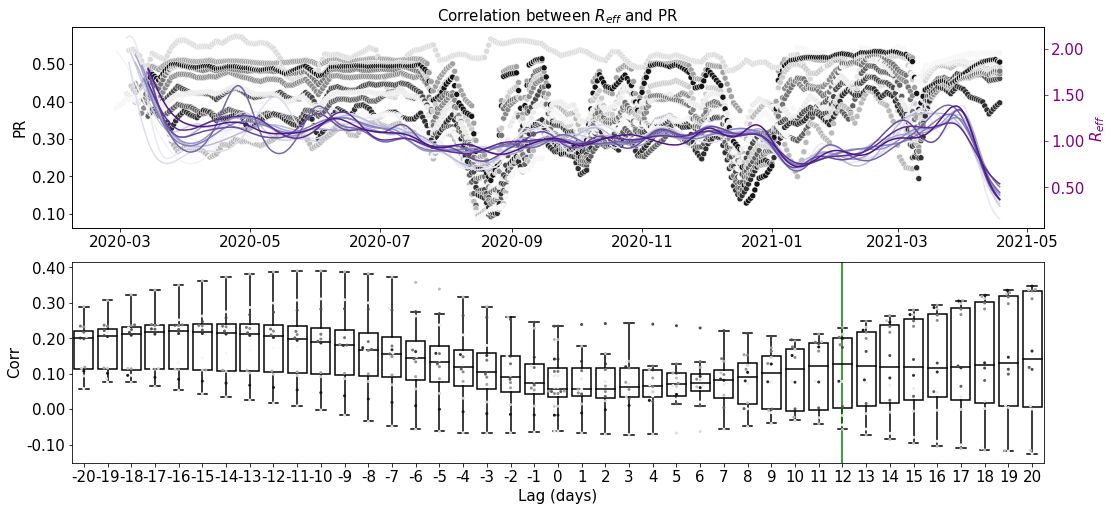

In [61]:
import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(15.5, 7.2))


ax1 = ax[0].twinx()
sns.scatterplot(ax=ax[0], data=df_all_pr, x="date", y="attribute_value", hue='location_id', palette='Greys')
sns.lineplot(ax=ax1, data=df_all_pr, x="date", y="median", hue='location_id', palette='Purples')
ax[0].set_ylabel('PR', fontsize=15)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

boxes = sns.boxplot(ax=ax[1], data=corr_all_pr_df, x="lags", y="value", color='white', showfliers=False, **PROPS)
sns.swarmplot(ax=ax[1], data=corr_all_pr_df, x="lags",  y="value", palette='Greys', hue="location_id", size=3)


for axi in ax:
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    axi.tick_params(axis='both', labelsize=15)
    axi.legend().set_visible(False)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax1.legend().set_visible(False)
ax1.tick_params(axis='both', labelsize=15)


ax[0].set_xlabel( None )
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Corr', fontsize=15)
ax[0].set_title(r'Correlation between $R_{eff}$ and PR', fontsize=15)
ax[1].axvline(x=12+20, color='green' )
ax1.yaxis.label.set_color('purple')
ax1.tick_params(axis='y', colors='purple')
ax1.set_ylabel(r'$R_{eff}$', fontsize=15)
ax[1].set_ylabel(r'Corr', fontsize=15)
ax[1].set_xlabel(r'Lag (days)', fontsize=15)
plt.tight_layout()

path_to_save =  os.path.join(results_dir, 'figures', 'pagerank_rt', 'PR_rt_corr_all.png')
fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=True)


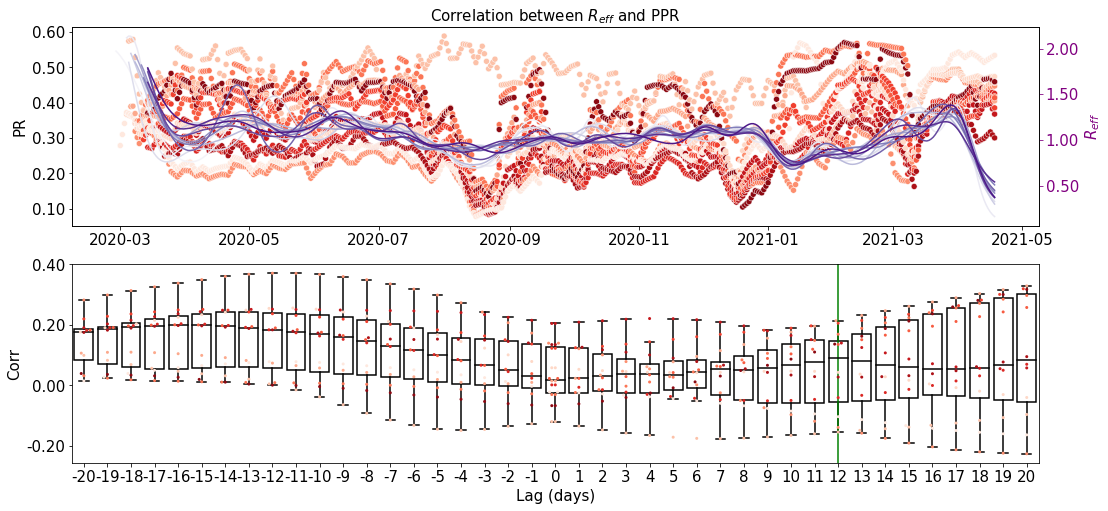

In [62]:

import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(15.5, 7.2))

ax1 = ax[0].twinx()
sns.scatterplot(ax=ax[0], data=df_all_ppr, x="date", y="attribute_value", hue='location_id', palette='Reds')
sns.lineplot(ax=ax1, data=df_all_pr, x="date", y="median", hue='location_id', palette='Purples')
ax[0].set_ylabel('PR', fontsize=15)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

boxes = sns.boxplot(ax=ax[1], data=corr_all_ppr_df, x="lags", y="value", color='white', showfliers=False, **PROPS)
sns.swarmplot(ax=ax[1], data=corr_all_ppr_df, x="lags",  y="value", palette='Reds', hue="location_id", size=3)

for axi in ax:
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    axi.tick_params(axis='both', labelsize=15)
    axi.legend().set_visible(False)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax1.legend().set_visible(False)
ax1.tick_params(axis='both', labelsize=15)


ax[0].set_xlabel( None )
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Corr', fontsize=15)
ax[0].set_title(r'Correlation between $R_{eff}$ and PPR', fontsize=15)
ax[1].axvline(x=12 + 20, color='green' )
ax1.yaxis.label.set_color('purple')
ax1.tick_params(axis='y', colors='purple')
ax1.set_ylabel(r'$R_{eff}$', fontsize=15)
ax[1].set_ylabel(r'Corr', fontsize=15)
ax[1].set_xlabel(r'Lag (days)', fontsize=15)
plt.tight_layout()
path_to_save =  os.path.join(results_dir, 'figures', 'pagerank_rt', 'PPR_rt_corr_all.png')
fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=True)


In [194]:

from PIL import Image

paths_ims = os.listdir( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PR'))
im1 = Image.open( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PR', paths_ims[0]) ).convert('RGB')
im_list = []
for p in paths_ims[1:]:
    im2 = Image.open( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PR', p)).convert('RGB')
    im_list.append(im2)
pdf1_filename = os.path.join(results_dir, "figures", "pagerank_rt", "PR_all.pdf")
im1.save(pdf1_filename, "PDF" , resolution=100.0, save_all=True, append_images=im_list)



paths_ims = os.listdir( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PPR'))
im1 = Image.open( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PPR', paths_ims[0]) ).convert('RGB')
im_list = []
for p in paths_ims[1:]:
    im2 = Image.open( os.path.join(results_dir, 'figures', 'pagerank_rt', 'PPR', p)).convert('RGB')
    im_list.append(im2)
pdf1_filename = os.path.join(results_dir, "figures", "pagerank_rt", "PPR_all.pdf")
im1.save(pdf1_filename, "PDF" , resolution=100.0, save_all=True, append_images=im_list)
